# Multi-Agent Reinforcement Learning: Scalability Analysis

## Overview
This section implements and analyzes **Independent Q-Learning (IQL) with Parameter Sharing** for a cooperative multi-agent taxi problem. We systematically study how system performance degrades as the number of agents increases from 2 to 5.

### Research Questions
1. How does agent utilization change as we scale from N=2 to N=5 agents?
2. What is the optimal number of agents for this single-passenger task?
3. How much computational efficiency is wasted with redundant agents?

### Key Features
- **Dynamic Agent Scaling**: Configurable from 2-5 agents
- **7×7 Grid Environment**: Larger state space than classic Taxi-v3
- **Auto-Stoppage**: Training halts automatically upon convergence
- **Parameter Sharing**: Single Q-table shared across all agents
- **Comprehensive Metrics**: Success rate, utilization, wasted steps

---

## 1. Library Imports and Dependencies

We use PettingZoo for multi-agent environments, Gymnasium for RL utilities, and standard scientific computing libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass
from gymnasium import spaces
from gymnasium.utils.seeding import np_random
from pettingzoo import ParallelEnv

---

## 2. Configuration and Hyperparameters

We define all experimental parameters in a single `Config` dataclass for reproducibility and easy tuning.

### Key Configuration Choices

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| **Learning Rate** | 0.15 | Higher than typical (0.1) for faster convergence in discrete space |
| **Discount Factor (γ)** | 0.95 | Balances immediate vs future rewards |
| **Epsilon Decay** | 0.99995 | Exponential decay for gradual exploitation |
| **Grid Size** | 7×7 | Larger than classic 5×5 to test scalability |
| **Max Steps** | 200 | Generous limit for 7×7 grid exploration |

### Auto-Stoppage Criteria
Training stops when ALL conditions are met for 3,000 consecutive episodes:
- Success Rate ≥ 99%
- Epsilon ≤ 0.015 (mostly exploiting)
- Steps Std Dev ≤ 5.0 (stable performance)

This ensures robust convergence before moving to the next agent configuration.

In [ ]:
@dataclass
class Config:
    # Training
    LEARNING_RATE: float = 0.15
    DISCOUNT_FACTOR: float = 0.95
    MAX_EPISODES: int = 500_000
    MAX_STEPS: int = 200
    
    # Exploration
    EPSILON_START: float = 1.0
    EPSILON_END: float = 0.01
    EPSILON_DECAY: float = 0.99995
    UCB_C: float = 2.0
    
    # Architecture
    PARAMETER_SHARING: bool = True
    LOCAL_OBS: bool = True
    
    # Logging and convergence
    LOG_INTERVAL: int = 2000
    CHECKPOINT_INTERVAL: int = 50_000
    CONVERGENCE_WINDOW: int = 5000
    
    # Auto-stoppage criteria
    MIN_SUCCESS_RATE: float = 0.99
    MAX_EPSILON_CONVERGED: float = 0.015
    MAX_STEPS_STD: float = 5.0  # More realistic for 7x7 grid with random spawns
    MIN_STABLE_EPISODES: int = 3000  # Must stay converged for this many episodes
    
    # Environment
    COOPERATIVE: bool = True
    GRID_SIZE: int = 7
    NUM_AGENTS: int = 2
    RENDER_MODE: str = "rgb_array"

config = Config()


---

## 3. Multi-Agent Taxi Environment

We implement a custom PettingZoo `ParallelEnv` that extends the classic Taxi problem to support 2-5 agents competing to serve a single passenger.

### Environment Dynamics

**State Space**: 
- Grid Size: 7×7 = 49 positions
- Passenger Status: 6 states (at R/G/Y/B, in my taxi, elsewhere)
- Destinations: 4 locations
- **Total States per Agent**: 49 × 6 × 4 = **1,176 states**

**Action Space**: 6 discrete actions
- 0-3: Movement (South, North, East, West)
- 4: Pickup passenger
- 5: Dropoff passenger

**Reward Structure** (Cooperative Mode):
| Event | Reward (per agent) | Purpose |
|-------|-------------------|---------|
| Step | -1 | Encourage efficiency |
| Collision | -0.5 | Discourage overlap |
| Moving closer | +0.3 | Shaped reward for guidance |
| Successful pickup | +15 | Milestone reward |
| Successful dropoff | +40 | Task completion bonus |
| Illegal action | -10 | Prevent invalid moves |

### Key Design Decisions

1. **Local Observations**: Each agent observes only its own position and task status, not other agents' positions. This reduces state space complexity from 15,000 to 1,176 states.

2. **Contribution Tracking**: Only the agent performing successful dropoff gets "contribution" credit, enabling precise utilization analysis.

3. **Random Action Order**: Pickup/dropoff actions are processed in random order each step to fairly break ties when multiple agents reach the passenger simultaneously.

In [ ]:
class MultiTaxiEnv(ParallelEnv):
    metadata = {"render_modes": ["ansi", "rgb_array"], "name": "multi_taxi_7x7"}
    
    TAXI_COLORS = [
        (255, 165, 0),   # Orange
        (0, 255, 255),   # Cyan
        (128, 0, 128),   # Purple
        (255, 0, 255),   # Magenta
        (0, 128, 128)    # Teal
    ]
    PASSENGER_COLOR = (255, 255, 255)
    
    def __init__(self, num_agents=2, grid_size=7, cooperative=True, local_obs=True):
        # Use underscore prefix to avoid conflict with ParallelEnv's num_agents property
        self._num_agents = num_agents
        self.grid_size = grid_size
        self.cooperative = cooperative
        self.local_obs = local_obs
        self._np_random = None
        self._seed = None
        
        # 7x7 grid destinations (corners)
        self.locs = [(0, 0), (0, 6), (6, 0), (6, 6)]
        
        # Agents
        self.possible_agents = [f"taxi_{i}" for i in range(num_agents)]
        self.agents = self.possible_agents[:]
        
        # Action space: 0-3 move, 4 pickup, 5 dropoff
        self.action_spaces = {agent: spaces.Discrete(6) for agent in self.agents}
        
        # State space: (MyRow, MyCol, PassStatus, Dest)
        # PassStatus: 0-3 (at location), 4 (in my taxi), 5 (elsewhere)
        pass_status_size = 6
        dest_size = 4
        state_size = grid_size * grid_size * pass_status_size * dest_size
        
        self.observation_spaces = {
            agent: spaces.Discrete(state_size) for agent in self.agents
        }
    
    @property
    def num_agents(self):
        """Override to return our custom num_agents"""
        return self._num_agents
    
    def action_space(self, agent):
        return self.action_spaces[agent]
    
    def observation_space(self, agent):
        return self.observation_spaces[agent]
    
    @property
    def np_random(self):
        if self._np_random is None:
            self._np_random, self._seed = np_random(self._seed)
        return self._np_random
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            self._seed = seed
            self._np_random, _ = np_random(seed)
        
        self.agents = self.possible_agents[:]
        self.timestep = 0
        
        # Random taxi positions
        self.taxi_locs = {
            agent: [self.np_random.integers(self.grid_size), 
                   self.np_random.integers(self.grid_size)]
            for agent in self.possible_agents
        }
        
        # Passenger location and destination
        self.pass_idx = self.np_random.integers(4)
        self.pass_loc = list(self.locs[self.pass_idx])
        
        self.dest_idx = self.np_random.integers(4)
        while self.dest_idx == self.pass_idx:
            self.dest_idx = self.np_random.integers(4)
        
        # Status: 0=waiting, 1-N=in taxi i, N+1=delivered
        self.pass_status = 0
        
        observations = {a: self._encode_obs(a) for a in self.agents}
        infos = {a: {} for a in self.agents}
        
        return observations, infos
    
    def step(self, actions):
        rewards = {a: -1 for a in self.agents}  # Step penalty
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        infos = {a: {'acted': False, 'contributed': False} for a in self.agents}
        
        # Track initial distances for reward shaping
        initial_dists = self._compute_distances()
        
        # Execute movements
        for agent in self.agents:
            action = actions.get(agent, 0)
            if action >= 4:
                continue
            
            row, col = self.taxi_locs[agent]
            new_row, new_col = row, col
            
            if action == 0:    # South
                new_row = min(row + 1, self.grid_size - 1)
            elif action == 1:  # North
                new_row = max(row - 1, 0)
            elif action == 2:  # East
                new_col = min(col + 1, self.grid_size - 1)
            elif action == 3:  # West
                new_col = max(col - 1, 0)
            
            self.taxi_locs[agent] = [new_row, new_col]
        
        # Collision penalty
        locations = list(self.taxi_locs.values())
        for i in range(len(locations)):
            for j in range(i + 1, len(locations)):
                if locations[i] == locations[j]:
                    agent_i = self.possible_agents[i]
                    agent_j = self.possible_agents[j]
                    rewards[agent_i] -= 0.5
                    rewards[agent_j] -= 0.5
        
        # Reward shaping: bonus for getting closer
        new_dists = self._compute_distances()
        for agent in self.agents:
            dist_improvement = initial_dists[agent] - new_dists[agent]
            rewards[agent] += 0.3 * dist_improvement
        
        # Process pickup/dropoff (in random order to break ties)
        agents_order = self.agents[:]
        self.np_random.shuffle(agents_order)
        
        for agent in agents_order:
            action = actions.get(agent, 0)
            if action < 4:
                continue
            
            agent_idx = int(agent.split('_')[1])
            
            if action == 4:  # Pickup
                if self.pass_status == 0 and self.taxi_locs[agent] == self.pass_loc:
                    self.pass_status = agent_idx + 1
                    infos[agent]['acted'] = True
                    # Don't mark as contributed yet - only dropoff counts
                    
                    if self.cooperative:
                        for a in self.agents:
                            rewards[a] += 15
                    else:
                        rewards[agent] += 20
                        for a in self.agents:
                            if a != agent:
                                rewards[a] -= 5
                else:
                    rewards[agent] -= 10
                    infos[agent]['acted'] = True
            
            elif action == 5:  # Dropoff
                carrying = (self.pass_status == agent_idx + 1)
                
                if carrying:
                    dest_loc = list(self.locs[self.dest_idx])
                    if self.taxi_locs[agent] == dest_loc:
                        infos[agent]['acted'] = True
                        infos[agent]['contributed'] = True  # ONLY successful dropoff counts
                        
                        if self.cooperative:
                            for a in self.agents:
                                rewards[a] += 40
                        else:
                            rewards[agent] += 50
                        
                        terminations = {a: True for a in self.agents}
                        self.pass_status = self._num_agents + 1
                    else:
                        rewards[agent] -= 10
                        infos[agent]['acted'] = True
                else:
                    rewards[agent] -= 10
                    infos[agent]['acted'] = True
        
        observations = {a: self._encode_obs(a) for a in self.agents}
        
        self.timestep += 1
        if self.timestep >= config.MAX_STEPS:
            truncations = {a: True for a in self.agents}
        
        return observations, rewards, terminations, truncations, infos
    
    def _compute_distances(self):
        """Compute Manhattan distance to goal for each agent"""
        distances = {}
        for agent in self.agents:
            agent_idx = int(agent.split('_')[1])
            
            if self.pass_status == 0:
                # Distance to passenger
                dist = (abs(self.taxi_locs[agent][0] - self.pass_loc[0]) +
                       abs(self.taxi_locs[agent][1] - self.pass_loc[1]))
            elif self.pass_status == agent_idx + 1:
                # Distance to destination (if carrying)
                dest = self.locs[self.dest_idx]
                dist = (abs(self.taxi_locs[agent][0] - dest[0]) +
                       abs(self.taxi_locs[agent][1] - dest[1]))
            else:
                dist = 0  # Not relevant for this agent
            
            distances[agent] = dist
        
        return distances
    
    def _encode_obs(self, agent_id):
        """Encode local observation as integer"""
        my_row, my_col = self.taxi_locs[agent_id]
        
        # Passenger status from this agent's perspective
        agent_idx = int(agent_id.split('_')[1])
        if self.pass_status == 0:
            pass_idx = self.pass_idx  # At one of 4 locations
        elif self.pass_status == agent_idx + 1:
            pass_idx = 4  # In my taxi
        else:
            pass_idx = 5  # Elsewhere (other taxi or delivered)
        
        dest_idx = self.dest_idx
        
        # Encode as single integer
        state = my_row
        state = state * self.grid_size + my_col
        state = state * 6 + pass_idx
        state = state * 4 + dest_idx
        
        return state

---

## 4. Shared Q-Learning Agent with UCB Exploration

We implement a single Q-learning agent whose Q-table is shared across all taxis in the system (parameter sharing).

### Algorithm: Q-Learning with Modifications

**Standard Q-Learning Update**:
$$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

**UCB Exploration Bonus**:
$$\text{UCB}(s,a) = Q(s,a) + c\sqrt{\frac{\ln(t)}{N(s,a)}}$$

Where:
- $\alpha$ = 0.15 (learning rate)
- $\gamma$ = 0.95 (discount factor)
- $c$ = 2.0 (exploration constant)
- $t$ = total steps taken
- $N(s,a)$ = visit count for state-action pair

### Why Parameter Sharing?

**Advantages**:
- Faster learning: All agents contribute to the same Q-table
- Better generalization: 5 agents × 100k episodes = 500k experiences
- Reduced memory: 1 Q-table instead of N

**Trade-off**:
- Agents are homogeneous (learn identical policies)
- Cannot specialize for different roles

---

## Training Loop with Convergence Detection

The training function implements:
1. **Episodic learning**: Reset environment → Act → Learn → Repeat
2. **Rolling window metrics**: Track success rate and steps over last 5,000 episodes
3. **Multi-stage convergence**: Must maintain criteria for 3,000 consecutive episodes
4. **Early stopping**: Saves computational resources when optimal policy is found

In [ ]:
class SharedQAgent:
    """Q-Learning agent with parameter sharing and UCB exploration"""
    
    def __init__(self, state_size, action_size, agent_ids):
        self.q_table = np.zeros((state_size, action_size))
        self.visit_counts = np.ones((state_size, action_size))
        self.epsilon = config.EPSILON_START
        self.agent_ids = agent_ids
        self.total_steps = 0
    
    def choose_action(self, state, training=True):
        """Epsilon-greedy with UCB exploration bonus"""
        if not training:
            return np.argmax(self.q_table[state])
        
        if np.random.random() < self.epsilon:
            return np.random.randint(self.q_table.shape[1])
        
        # UCB exploration
        q_values = self.q_table[state]
        visits = self.visit_counts[state]
        
        exploration_bonus = config.UCB_C * np.sqrt(
            np.log(max(self.total_steps, 1)) / visits
        )
        ucb_values = q_values + exploration_bonus
        
        return np.argmax(ucb_values)
    
    def update(self, state, action, reward, next_state):
        """Q-learning update"""
        self.visit_counts[state, action] += 1
        self.total_steps += 1
        
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        
        new_value = old_value + config.LEARNING_RATE * (
            reward + config.DISCOUNT_FACTOR * next_max - old_value
        )
        self.q_table[state, action] = new_value
    
    def decay_epsilon(self):
        """Exponential decay"""
        self.epsilon = max(config.EPSILON_END, self.epsilon * config.EPSILON_DECAY)

# ============================================================================
# TRAINING WITH AUTO-STOPPAGE
# ============================================================================

def train(num_agents):
    """Train agents with automatic convergence detection"""
    env = MultiTaxiEnv(
        num_agents=num_agents,
        grid_size=config.GRID_SIZE,
        cooperative=config.COOPERATIVE,
        local_obs=config.LOCAL_OBS
    )
    
    state_size = env.observation_spaces["taxi_0"].n
    action_size = 6
    
    print(f"\n{'='*60}")
    print(f"Training N={num_agents} Agents")
    print(f"{'='*60}")
    print(f"State size: {state_size} | Action size: {action_size}")
    print(f"Grid: {config.GRID_SIZE}x{config.GRID_SIZE}")
    print(f"Auto-stoppage criteria:")
    print(f"  • Success Rate ≥ {config.MIN_SUCCESS_RATE*100:.0f}%")
    print(f"  • Epsilon ≤ {config.MAX_EPSILON_CONVERGED:.3f}")
    print(f"  • Steps Std Dev ≤ {config.MAX_STEPS_STD:.1f}")
    print(f"  • Stable for {config.MIN_STABLE_EPISODES:,} episodes")
    print(f"{'='*60}\n")
    
    # Initialize shared agent
    agent = SharedQAgent(state_size, action_size, env.possible_agents)
    agents = {a: agent for a in env.possible_agents}
    
    # Tracking metrics
    rewards_history = defaultdict(list)
    steps_history = []
    success_window = deque(maxlen=config.CONVERGENCE_WINDOW)
    steps_window = deque(maxlen=config.CONVERGENCE_WINDOW)
    
    converged = False
    convergence_counter = 0  # Track how long we've been converged
    final_episode = 0
    
    for episode in range(1, config.MAX_EPISODES + 1):
        obs, _ = env.reset()
        episode_rewards = defaultdict(int)
        
        for step in range(config.MAX_STEPS):
            # Choose actions
            actions = {
                agent_id: agents[agent_id].choose_action(obs[agent_id])
                for agent_id in env.agents
            }
            
            # Step environment
            next_obs, rewards, term, trunc, _ = env.step(actions)
            
            # Update Q-values
            for agent_id in env.agents:
                agents[agent_id].update(
                    obs[agent_id],
                    actions[agent_id],
                    rewards[agent_id],
                    next_obs[agent_id]
                )
                episode_rewards[agent_id] += rewards[agent_id]
            
            obs = next_obs
            
            if any(term.values()) or any(trunc.values()):
                success = 1 if any(term.values()) else 0
                success_window.append(success)
                steps_window.append(step + 1)
                steps_history.append(step + 1)
                break
        
        # Record rewards
        for agent_id in env.possible_agents:
            rewards_history[agent_id].append(episode_rewards[agent_id])
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Check convergence
        if episode >= config.CONVERGENCE_WINDOW:
            success_rate = np.mean(success_window)
            steps_std = np.std(steps_window)
            steps_mean = np.mean(steps_window)
            
            # Check if all criteria are met
            meets_success = success_rate >= config.MIN_SUCCESS_RATE
            meets_epsilon = agent.epsilon <= config.MAX_EPSILON_CONVERGED
            meets_stability = steps_std <= config.MAX_STEPS_STD
            
            if meets_success and meets_epsilon and meets_stability:
                convergence_counter += 1
                
                # Must stay converged for MIN_STABLE_EPISODES
                if convergence_counter >= config.MIN_STABLE_EPISODES:
                    print(f"\n{'*'*60}")
                    print(f"CONVERGED at Episode {episode}!")
                    print(f"  Success Rate: {success_rate*100:.2f}%")
                    print(f"  Avg Steps: {steps_mean:.2f} (std: {steps_std:.2f})")
                    print(f"  Epsilon: {agent.epsilon:.6f}")
                    print(f"  Stable for: {convergence_counter:,} episodes")
                    print(f"{'*'*60}\n")
                    
                    converged = True
                    final_episode = episode
                    break
            else:
                # Reset counter if criteria not met
                convergence_counter = 0
        
        # Periodic logging
        if episode % config.LOG_INTERVAL == 0:
            if len(success_window) > 0:
                success_rate = np.mean(success_window) * 100
                avg_steps = np.mean(steps_window)
                avg_reward = np.mean([rewards_history[a][-config.LOG_INTERVAL:] 
                                     for a in env.possible_agents])
                
                print(f"Ep {episode:6d} | "
                      f"Success: {success_rate:5.1f}% | "
                      f"Steps: {avg_steps:5.1f} | "
                      f"Reward: {avg_reward:6.1f} | "
                      f"ε: {agent.epsilon:.4f}")
    
    if not converged:
        final_episode = config.MAX_EPISODES
        print(f"\nReached max episodes ({config.MAX_EPISODES}) without full convergence")
    
    return agents, rewards_history, steps_history, final_episode, converged


---

## 5. Evaluation and Utilization Analysis

After training, we evaluate the learned policy on 100 test episodes to measure real-world performance.

### Metrics Tracked

#### Performance Metrics
- **Success Rate**: % of episodes where passenger is successfully delivered
- **Average Steps**: Mean episode length for successful deliveries
- **Average Reward**: Mean cumulative reward per agent per episode

#### Utilization Metrics (Novel Contribution)
- **Agent Contribution**: Binary indicator — did this agent perform the final dropoff?
- **Utilization Rate**: `(# contributions / # successful episodes) × 100%`
- **Wasted Steps**: `(N - 1) × episode_length` for non-contributing agents

### Why Utilization Matters

In a single-passenger system with N agents:
- **Optimal case**: Only 1 agent works, others remain idle
- **Expected utilization**: ~100/N % per agent (uniform distribution)
- **Wasted resources**: As N increases, more agent-steps are wasted

**Example**: 
- N=5, episode length=14 steps, 1 agent contributes
- Wasted steps = 4 × 14 = **56 wasted agent-steps**

This metric quantifies the **coordination inefficiency** inherent in over-provisioned multi-agent systems.

In [ ]:
def evaluate(agents, num_agents, num_episodes=100):
    """Evaluate trained policy with detailed agent utilization metrics"""
    env = MultiTaxiEnv(
        num_agents=num_agents,
        grid_size=config.GRID_SIZE,
        cooperative=config.COOPERATIVE,
        local_obs=config.LOCAL_OBS
    )
    
    success_count = 0
    total_steps = 0
    total_rewards = defaultdict(int)
    
    # NEW: Track agent utilization
    agent_contributions = defaultdict(int)  # How many times each agent contributed
    agent_actions = defaultdict(int)  # How many pickup/dropoff actions attempted
    total_wasted_steps = 0  # Steps taken by agents that didn't contribute
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = defaultdict(int)
        episode_contributed = set()  # Track which agents contributed this episode
        
        for step in range(config.MAX_STEPS):
            actions = {
                agent_id: agents[agent_id].choose_action(obs[agent_id], training=False)
                for agent_id in env.agents
            }
            
            next_obs, rewards, term, trunc, infos = env.step(actions)
            
            # Track contributions
            for agent_id in env.agents:
                episode_reward[agent_id] += rewards[agent_id]
                
                if infos[agent_id]['contributed']:
                    episode_contributed.add(agent_id)
                    agent_contributions[agent_id] += 1
                
                if infos[agent_id]['acted']:
                    agent_actions[agent_id] += 1
            
            obs = next_obs
            
            if any(term.values()) or any(trunc.values()):
                if any(term.values()):
                    success_count += 1
                    total_steps += step + 1
                    
                    # Calculate wasted steps: (N-1) * steps for agents that didn't contribute
                    num_contributors = len(episode_contributed)
                    num_wasted_agents = num_agents - num_contributors
                    total_wasted_steps += num_wasted_agents * (step + 1)
                
                break
        
        for agent_id in env.possible_agents:
            total_rewards[agent_id] += episode_reward[agent_id]
    
    success_rate = (success_count / num_episodes) * 100
    avg_steps = total_steps / max(success_count, 1)
    avg_reward = np.mean([total_rewards[a] for a in env.possible_agents]) / num_episodes
    
    # Calculate utilization metrics
    total_successful_episodes = success_count
    avg_wasted_steps_per_episode = total_wasted_steps / max(success_count, 1)
    
    utilization_rate = {}
    for agent_id in env.possible_agents:
        utilization_rate[agent_id] = (agent_contributions[agent_id] / max(total_successful_episodes, 1)) * 100
    
    avg_utilization = np.mean(list(utilization_rate.values()))
    
    return {
        'success_rate': success_rate,
        'avg_steps': avg_steps,
        'avg_reward': avg_reward,
        'total_rewards': total_rewards,
        'agent_contributions': dict(agent_contributions),
        'agent_actions': dict(agent_actions),
        'utilization_rate': utilization_rate,
        'avg_utilization': avg_utilization,
        'avg_wasted_steps': avg_wasted_steps_per_episode,
        'total_wasted_steps': total_wasted_steps
    }

In [29]:
# ============================================================================
# PLOTTING
# ============================================================================

def plot_training_curves(all_histories, all_episodes):
    """Plot reward and steps convergence for each N"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training Convergence by Number of Agents', fontsize=14, fontweight='bold')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    window = 500
    
    for idx, N in enumerate(range(2, 6)):
        if N not in all_histories:
            continue
        
        history = all_histories[N]
        final_ep = all_episodes[N]
        
        # Plot rewards
        ax = axes[0, idx % 2] if idx < 2 else axes[1, idx % 2]
        
        rewards = history['rewards'][f'taxi_0']
        if len(rewards) >= window:
            rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            episodes = range(window, len(rewards) + 1)
            ax.plot(episodes, rolling_avg, color=colors[idx], linewidth=2)
        
        ax.set_title(f'N={N} Agents (Converged at {final_ep:,} eps)', fontweight='bold')
        ax.set_xlabel('Episode')
        ax.set_ylabel(f'Avg Reward (window={window})')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Steps plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Steps to Completion by Number of Agents', fontsize=14, fontweight='bold')
    
    for idx, N in enumerate(range(2, 6)):
        if N not in all_histories:
            continue
        
        history = all_histories[N]
        steps = history['steps']
        
        ax = axes[idx // 2, idx % 2]
        
        if len(steps) >= window:
            rolling_avg = np.convolve(steps, np.ones(window)/window, mode='valid')
            episodes = range(window, len(steps) + 1)
            ax.plot(episodes, rolling_avg, color=colors[idx], linewidth=2)
        
        ax.set_title(f'N={N} Agents', fontweight='bold')
        ax.set_xlabel('Episode')
        ax.set_ylabel(f'Avg Steps (window={window})')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_scalability_analysis(results):
    """Plot how performance scales with number of agents"""
    N_values = sorted(results.keys())
    
    success_rates = [results[N]['success_rate'] for N in N_values]
    avg_steps = [results[N]['avg_steps'] for N in N_values]
    avg_rewards = [results[N]['avg_reward'] for N in N_values]
    episodes_to_converge = [results[N]['episodes'] for N in N_values]
    utilization_rates = [results[N]['avg_utilization'] for N in N_values]
    wasted_steps = [results[N]['avg_wasted_steps'] for N in N_values]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Scalability Analysis: Performance vs Number of Agents', 
                 fontsize=14, fontweight='bold')
    
    # Success rate
    axes[0, 0].plot(N_values, success_rates, 'o-', linewidth=2, markersize=8, color='#2ca02c')
    axes[0, 0].set_title('Success Rate vs N', fontweight='bold')
    axes[0, 0].set_xlabel('Number of Agents (N)')
    axes[0, 0].set_ylabel('Success Rate (%)')
    axes[0, 0].set_xticks(N_values)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 105])
    
    # Steps to completion
    axes[0, 1].plot(N_values, avg_steps, 's-', linewidth=2, markersize=8, color='#ff7f0e')
    axes[0, 1].set_title('Avg Steps (on success) vs N', fontweight='bold')
    axes[0, 1].set_xlabel('Number of Agents (N)')
    axes[0, 1].set_ylabel('Steps to Completion')
    axes[0, 1].set_xticks(N_values)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Average reward
    axes[0, 2].plot(N_values, avg_rewards, '^-', linewidth=2, markersize=8, color='#d62728')
    axes[0, 2].set_title('Avg Reward per Agent vs N', fontweight='bold')
    axes[0, 2].set_xlabel('Number of Agents (N)')
    axes[0, 2].set_ylabel('Average Reward')
    axes[0, 2].set_xticks(N_values)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Episodes to convergence
    axes[1, 0].bar(N_values, episodes_to_converge, color='#1f77b4', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Episodes to Convergence vs N', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Agents (N)')
    axes[1, 0].set_ylabel('Episodes')
    axes[1, 0].set_xticks(N_values)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # NEW: Agent Utilization Rate
    axes[1, 1].plot(N_values, utilization_rates, 'D-', linewidth=2, markersize=8, color='#9467bd')
    axes[1, 1].set_title('Agent Utilization Rate vs N', fontweight='bold')
    axes[1, 1].set_xlabel('Number of Agents (N)')
    axes[1, 1].set_ylabel('Utilization (%)')
    axes[1, 1].set_xticks(N_values)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 105])
    
    # NEW: Wasted Agent-Steps
    axes[1, 2].plot(N_values, wasted_steps, 'v-', linewidth=2, markersize=8, color='#e377c2')
    axes[1, 2].set_title('Wasted Agent-Steps vs N', fontweight='bold')
    axes[1, 2].set_xlabel('Number of Agents (N)')
    axes[1, 2].set_ylabel('Avg Wasted Steps per Episode')
    axes[1, 2].set_xticks(N_values)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_agent_utilization_breakdown(results):
    """Plot detailed per-agent utilization for each N"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Agent Utilization Breakdown by Configuration', fontsize=14, fontweight='bold')
    
    colors = plt.cm.Set3(np.linspace(0, 1, 5))
    
    for idx, N in enumerate(range(2, 6)):
        if N not in results:
            continue
        
        ax = axes[idx // 2, idx % 2]
        
        utilization = results[N]['utilization_rate']
        agents = sorted(utilization.keys())
        values = [utilization[a] for a in agents]
        
        bars = ax.bar(range(len(agents)), values, color=colors[:N], alpha=0.7, edgecolor='black')
        ax.set_title(f'N={N} Agents', fontweight='bold')
        ax.set_xlabel('Agent')
        ax.set_ylabel('Utilization Rate (%)')
        ax.set_xticks(range(len(agents)))
        ax.set_xticklabels([f'T{i}' for i in range(N)])
        ax.set_ylim([0, 105])
        ax.grid(True, alpha=0.3, axis='y')
        ax.axhline(y=100/N, color='r', linestyle='--', alpha=0.5, label=f'Equal Share ({100/N:.1f}%)')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=9)
        
        ax.legend()
    
    plt.tight_layout()
    plt.show()

MULTI-AGENT TAXI: SCALABILITY STUDY (N=2 to N=5)

Training N=2 Agents
State size: 1176 | Action size: 6
Grid: 7x7
Auto-stoppage criteria:
  • Success Rate ≥ 99%
  • Epsilon ≤ 0.015
  • Steps Std Dev ≤ 5.0
  • Stable for 3,000 episodes

Ep   2000 | Success:  29.5% | Steps: 179.5 | Reward: -722.7 | ε: 0.9048
Ep   4000 | Success:  58.0% | Steps: 148.8 | Reward: -401.7 | ε: 0.8187
Ep   6000 | Success:  82.7% | Steps: 111.1 | Reward: -211.3 | ε: 0.7408
Ep   8000 | Success:  98.3% | Steps:  72.2 | Reward: -120.5 | ε: 0.6703
Ep  10000 | Success:  99.9% | Steps:  51.8 | Reward:  -73.1 | ε: 0.6065
Ep  12000 | Success: 100.0% | Steps:  41.2 | Reward:  -45.9 | ε: 0.5488
Ep  14000 | Success: 100.0% | Steps:  34.8 | Reward:  -28.0 | ε: 0.4966
Ep  16000 | Success: 100.0% | Steps:  30.8 | Reward:  -14.9 | ε: 0.4493
Ep  18000 | Success: 100.0% | Steps:  27.8 | Reward:   -5.9 | ε: 0.4066
Ep  20000 | Success: 100.0% | Steps:  25.8 | Reward:    0.3 | ε: 0.3679
Ep  22000 | Success: 100.0% | Steps:  24.2 |

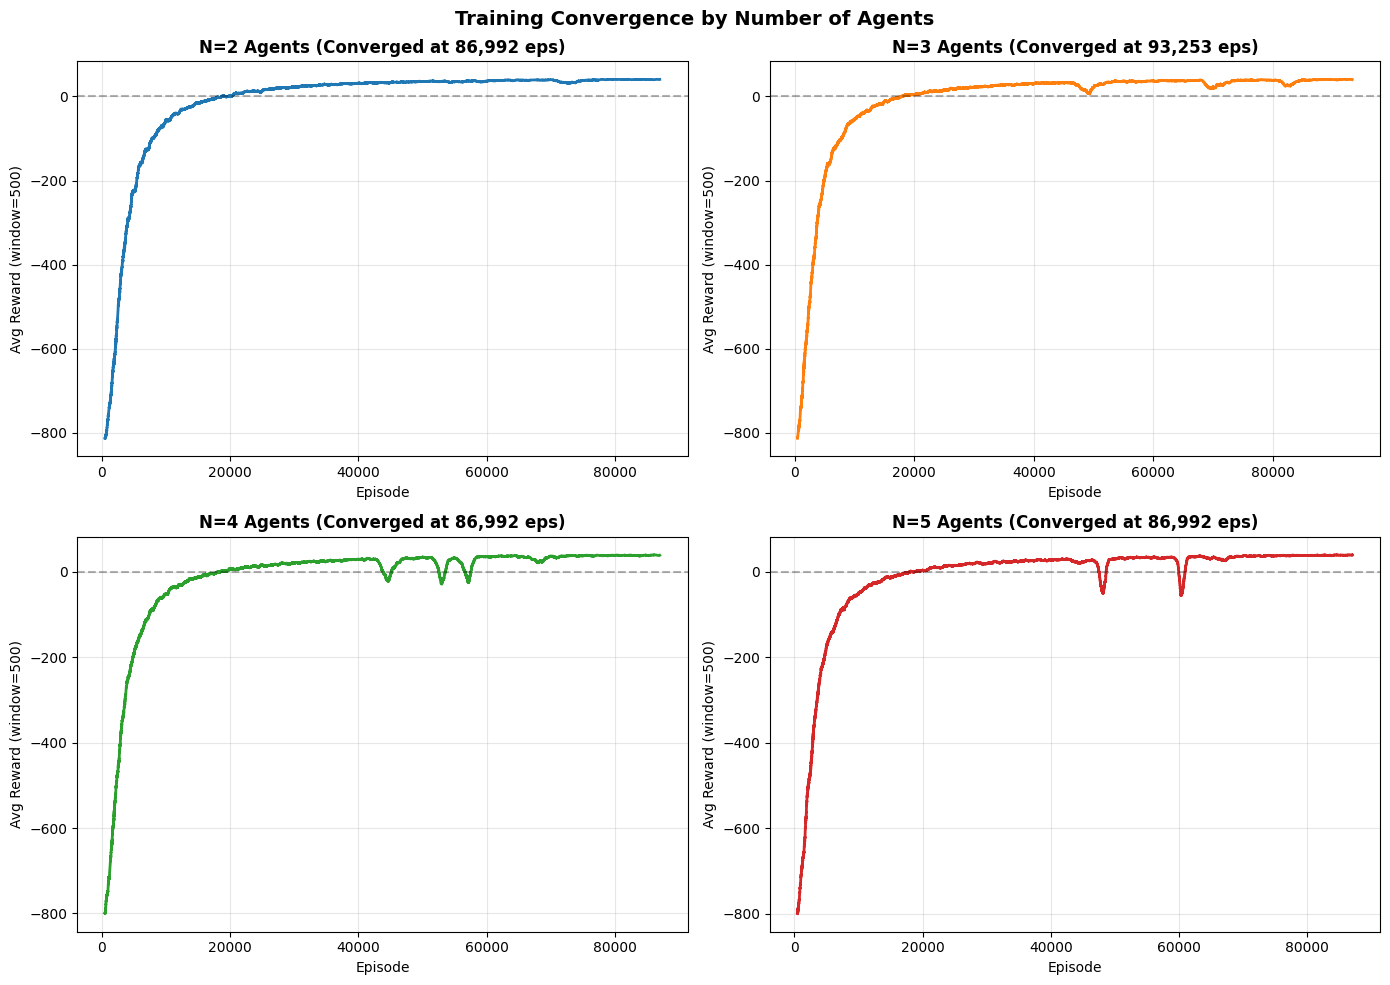

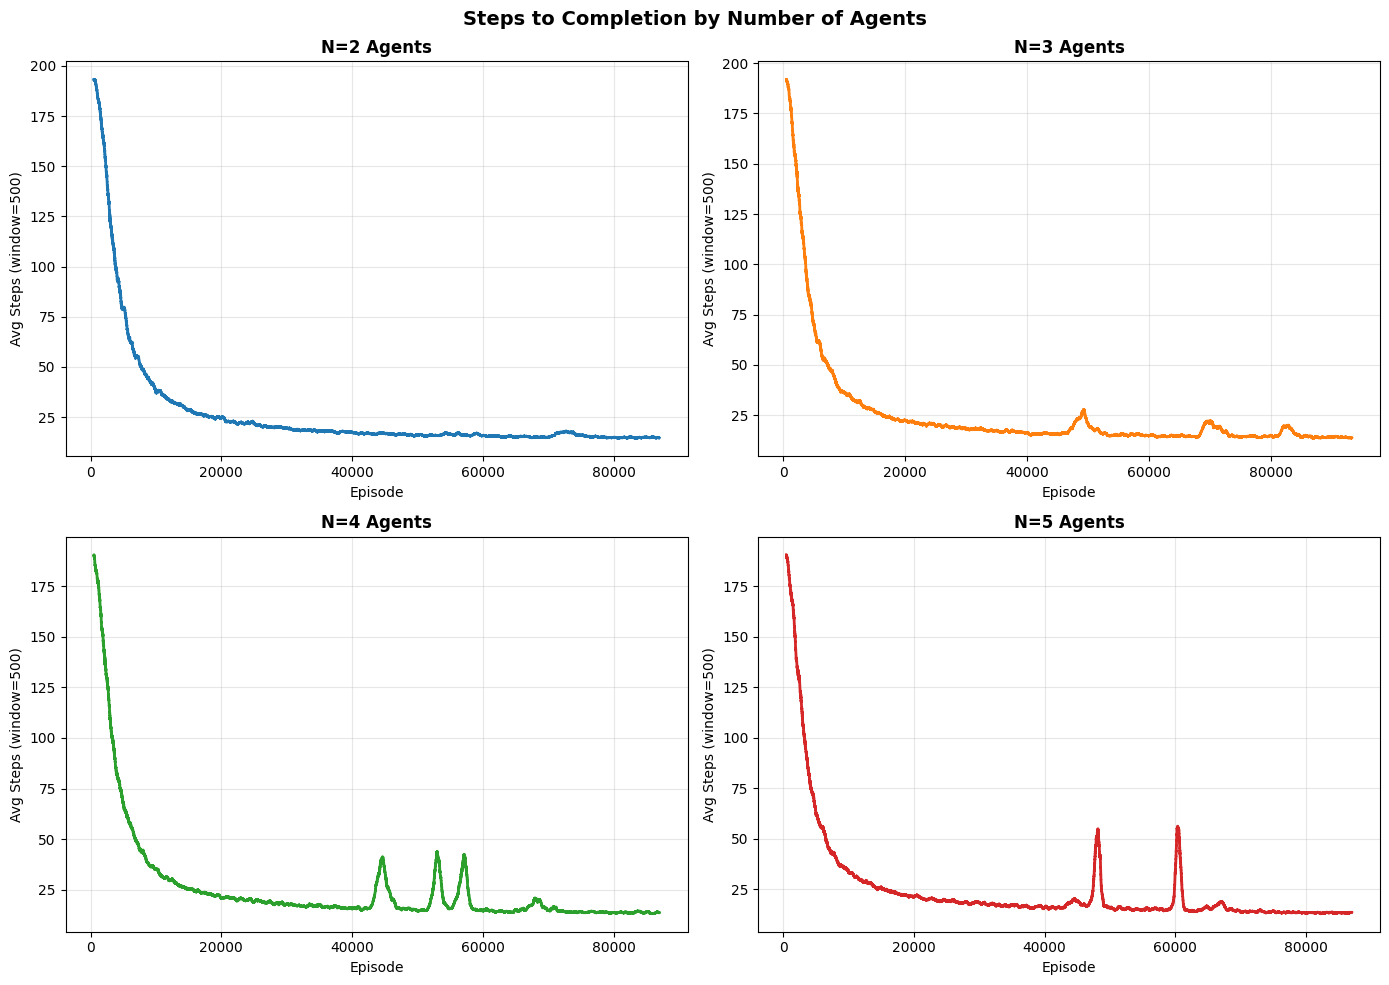

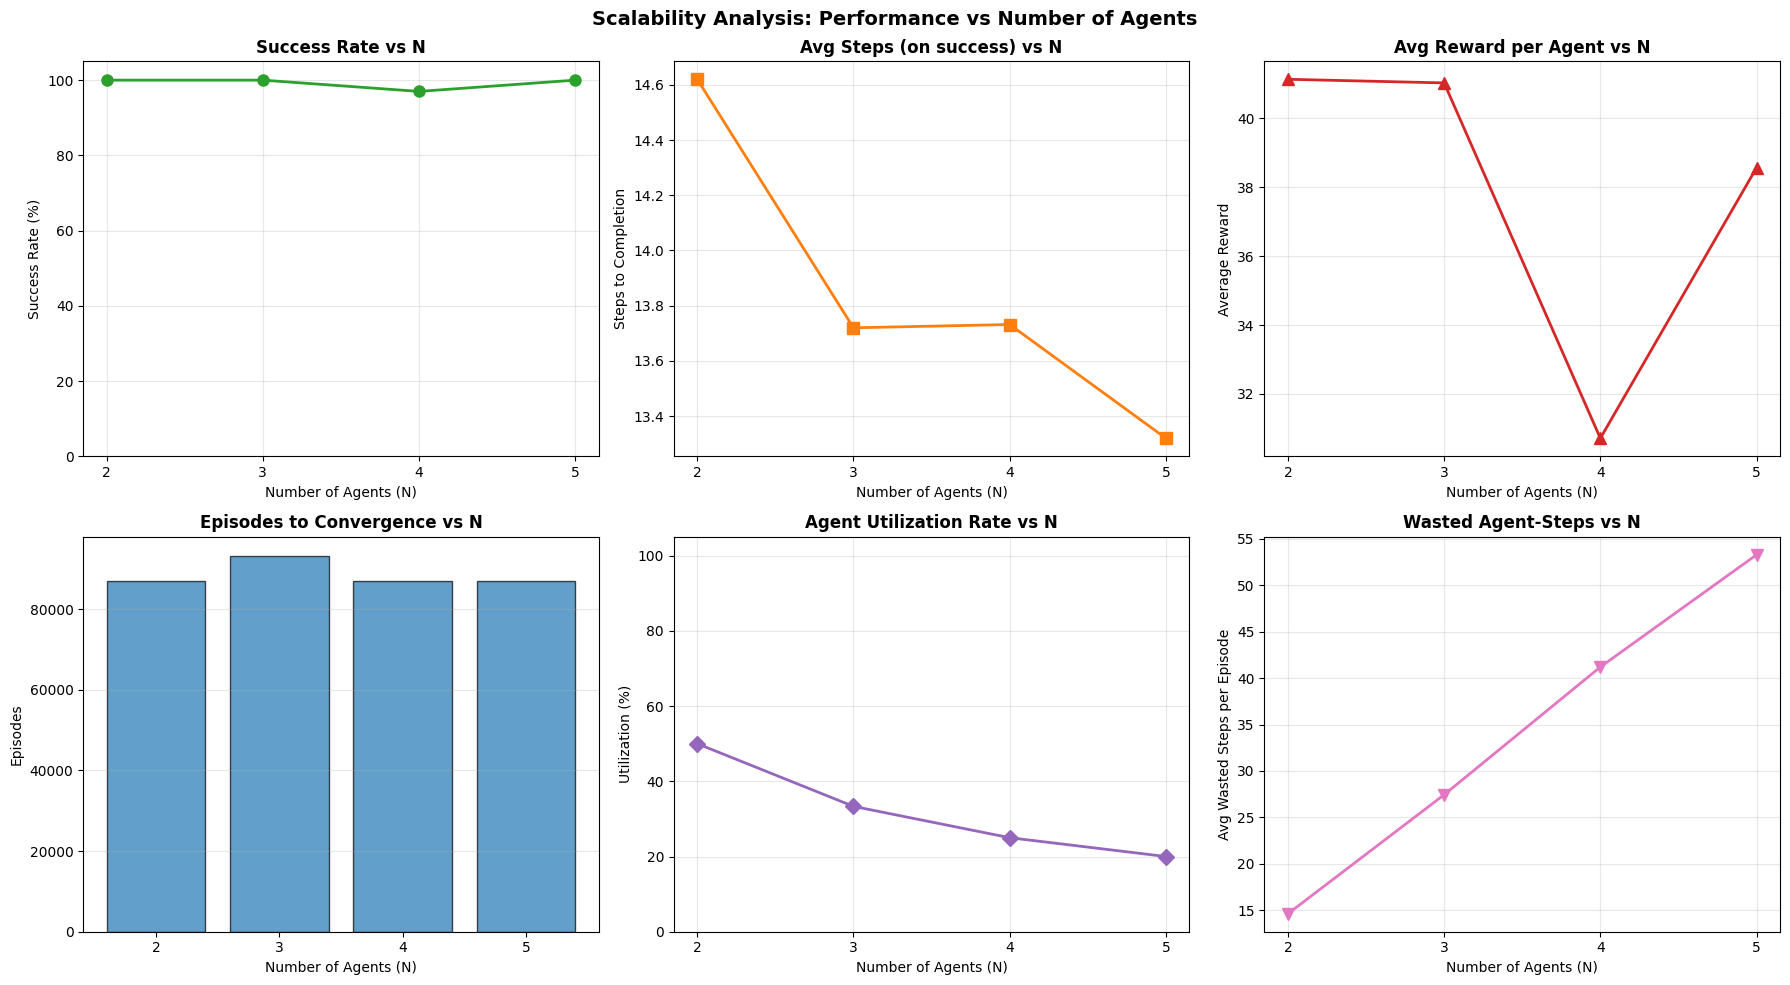

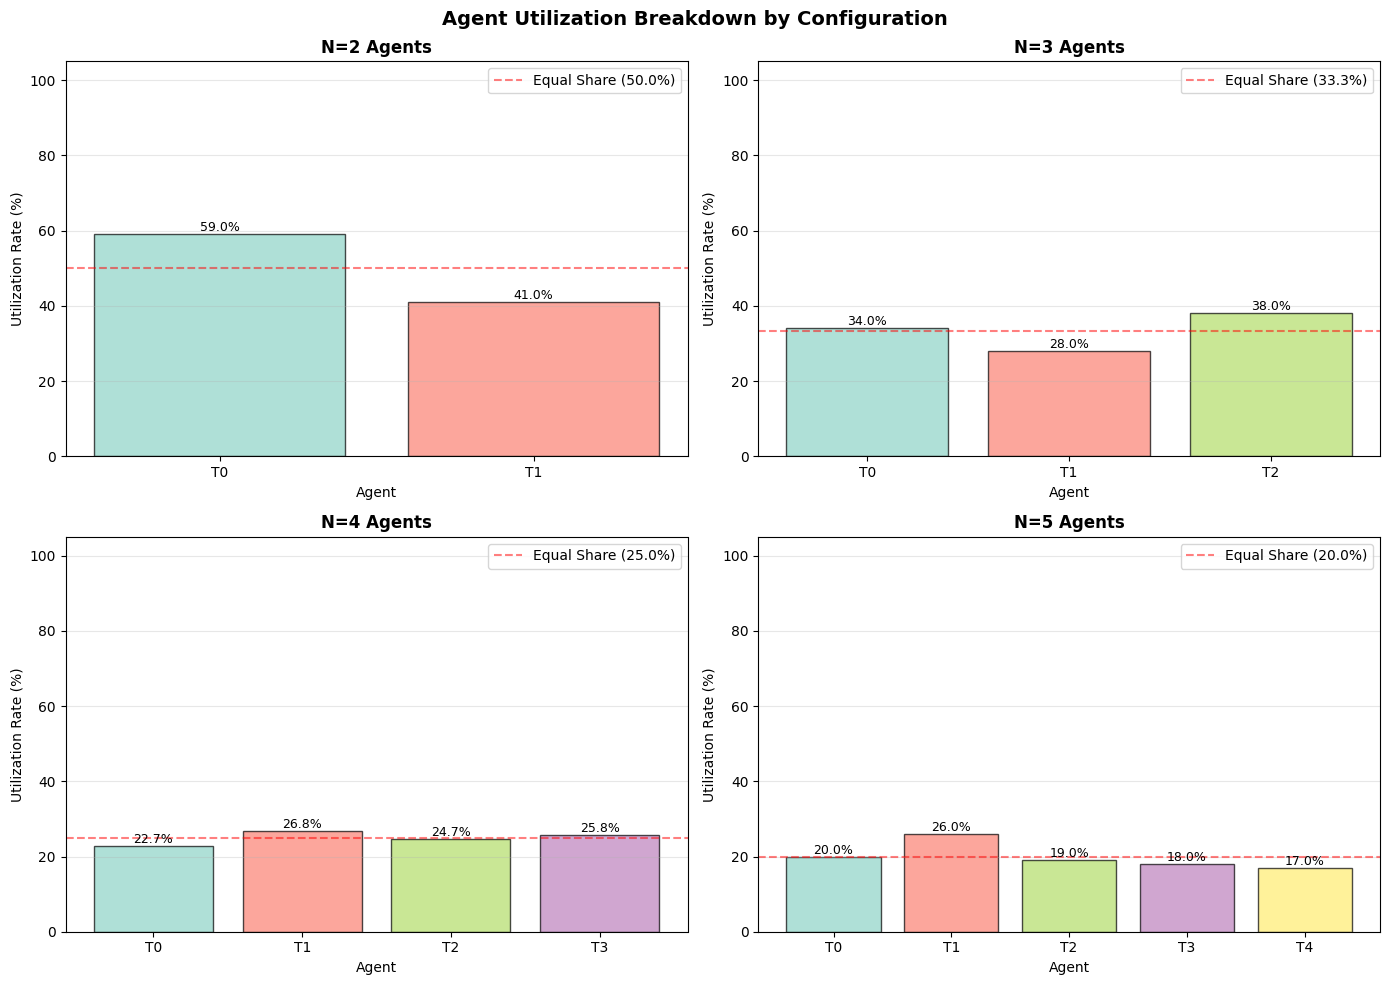


✓ Experiment complete!


In [30]:
# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

if __name__ == "__main__":
    print("="*70)
    print("MULTI-AGENT TAXI: SCALABILITY STUDY (N=2 to N=5)")
    print("="*70)
    
    all_results = {}
    all_histories = {}
    all_episodes = {}
    
    # Run experiments for N=2 to N=5
    for N in range(2, 6):
        # Train
        agents, rewards_hist, steps_hist, final_ep, converged = train(N)
        
        # Evaluate
        eval_metrics = evaluate(agents, N, num_episodes=100)
        
        # Store results
        all_results[N] = {
            'success_rate': eval_metrics['success_rate'],
            'avg_steps': eval_metrics['avg_steps'],
            'avg_reward': eval_metrics['avg_reward'],
            'episodes': final_ep,
            'converged': converged,
            'utilization_rate': eval_metrics['utilization_rate'],
            'avg_utilization': eval_metrics['avg_utilization'],
            'avg_wasted_steps': eval_metrics['avg_wasted_steps'],
            'agent_contributions': eval_metrics['agent_contributions']
        }
        
        all_histories[N] = {
            'rewards': rewards_hist,
            'steps': steps_hist
        }
        
        all_episodes[N] = final_ep
        
        # Save Q-table
        filename = f"q_table_N{N}_7x7.npy"
        np.save(filename, agents[f"taxi_0"].q_table)
        print(f"Saved: {filename}\n")
    
    # Print summary table
    print("\n" + "="*90)
    print("FINAL RESULTS SUMMARY")
    print("="*90)
    print(f"{'N':<5} {'Success%':<12} {'Avg Steps':<12} {'Avg Reward':<12} {'Utilization%':<14} {'Wasted Steps':<14} {'Episodes':<12} {'Conv.':<7}")
    print("-"*90)
    
    for N in sorted(all_results.keys()):
        r = all_results[N]
        print(f"{N:<5} {r['success_rate']:<12.1f} {r['avg_steps']:<12.1f} "
              f"{r['avg_reward']:<12.1f} {r['avg_utilization']:<14.1f} "
              f"{r['avg_wasted_steps']:<14.1f} {r['episodes']:<12,} "
              f"{'Yes' if r['converged'] else 'No':<7}")
    
    print("="*90)
    
    # Print detailed utilization breakdown
    print("\n" + "="*90)
    print("AGENT UTILIZATION BREAKDOWN (% of episodes where agent contributed)")
    print("="*90)
    for N in sorted(all_results.keys()):
        util = all_results[N]['utilization_rate']
        print(f"N={N}: ", end="")
        for agent_id in sorted(util.keys()):
            print(f"{agent_id}: {util[agent_id]:.1f}%  ", end="")
        print()
    print("="*90)
    
    # Generate plots
    print("\nGenerating plots...")
    plot_training_curves(all_histories, all_episodes)
    plot_scalability_analysis(all_results)
    plot_agent_utilization_breakdown(all_results)
    
    print("\n✓ Experiment complete!")